In [1]:
# Example from https://github.com/brian-team/brian2/blob/master/examples/synapses/STDP.py

In [2]:
from brian2 import *
import brian2lava

BrianLogger.log_level_debug()

#set_device('lava', mode='flexible')
#set_device('lava', mode='preset', print_models=True)

set_device('runtime')
prefs.codegen.target = 'numpy'

#device = get_device()
#device.reinit()
#device.activate()
#start_scope()

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

poisson_input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(poisson_input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1
                dApost/dt = -Apost / taupost : 1 ''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
s_mon = SpikeMonitor(poisson_input)

INFO       The synaptic equation for the variable Apost does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable Apre does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
DEBUG      Creating synapses from group 'poissongroup' to group 'neurongroup', using genera

In [3]:
run(0.1*second, report='text')

DEBUG      Updated MagicNetwork to include 12 objects with names poissongroup, synapses_post, spikemonitor, neurongroup_spike_resetter, synapses_stateupdater, neurongroup_spike_thresholder, synapses_pre, synapses, statemonitor, neurongroup, poissongroup_spike_thresholder, neurongroup_stateupdater [brian2.core.magic.magic_objects]
DEBUG      Preparing network 'magicnetwork' with 12 objects: neurongroup, statemonitor, synapses, neurongroup_stateupdater, synapses_stateupdater, neurongroup_spike_thresholder, poissongroup, poissongroup_spike_thresholder, spikemonitor, synapses_pre, synapses_post, neurongroup_spike_resetter [brian2.core.network.before_run]
DEBUG      Group neurongroup: using numerical integration method euler (took 0.01s) [brian2.stateupdaters.base.method_choice]
DEBUG      Group synapses: using numerical integration method exact (took 0.22s) [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'exa

Starting simulation at t=0. s for a duration of 100. ms
100. ms (100%) simulated in < 1s


DEBUG      Finished simulating network 'magicnetwork' (took 0.09s) [brian2.core.network.run]


In [4]:
print(f"Monitored weight values shape: {mon.w.shape}")
print(f"Final weight values of monitored synapses: {mon.w[:,-1]}")

Monitored weight values shape: (2, 1000)
Final weight values of monitored synapses: [0.00758565 0.00196542]


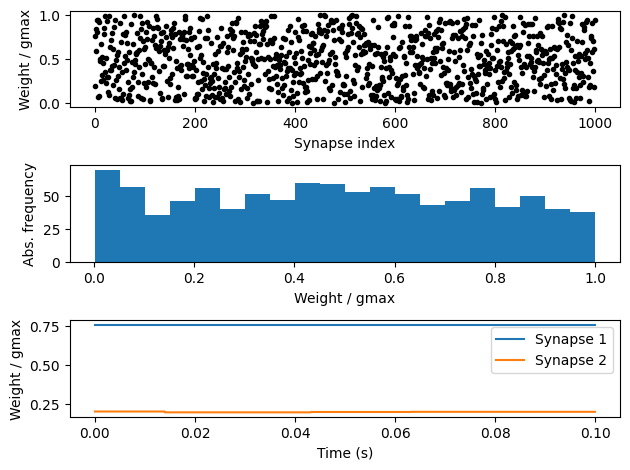

In [6]:
subplot(311)
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / gmax, 20)
xlabel('Weight / gmax')
ylabel('Abs. frequency')
subplot(313)
plot(mon.t/second, mon.w.T/gmax, label=["Synapse 1", "Synapse 2"])
xlabel('Time (s)')
ylabel('Weight / gmax')
legend()
tight_layout()
show()